## 0) Import Libraries and General Script

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

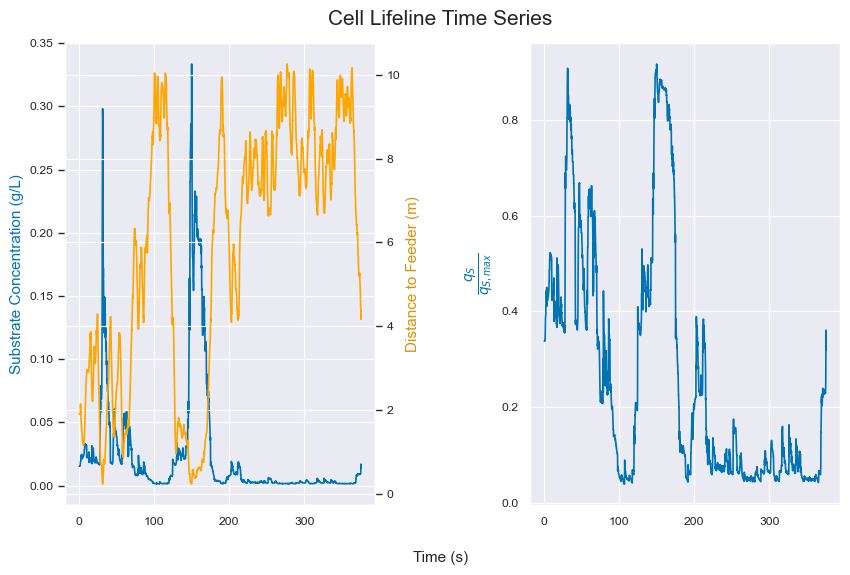

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


# Simple Methods to Reduce Cell Lifeline Data
Reduction of observations (Subsampling)

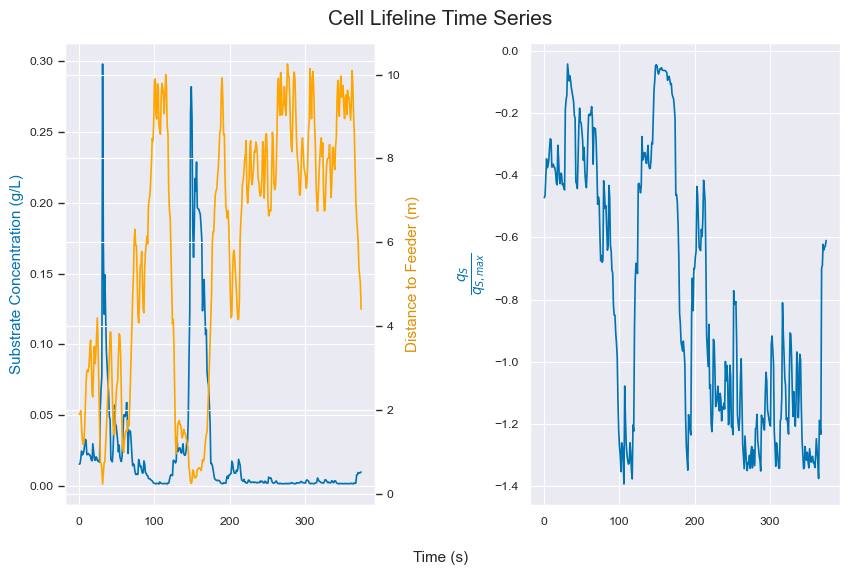

In [7]:
import numpy as np

# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Define the desired interval for selecting time points
interval = 10  # Select every 10th time point

# Reduce the dataset by selecting every n-th time point
reduced_time_array = time_array[::interval]
reduced_x_array = x_array[::interval]
reduced_y_array = y_array[::interval]
reduced_z_array = z_array[::interval]
reduced_C_S_array = C_S_array[::interval]

# Compute distance to feeding point for the reduced dataset
reduced_dist_feed_point = np.sqrt((reduced_x_array-x_feed)**2 + (reduced_y_array-y_feed)**2 + (reduced_z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point using the reduced dataset
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.lineplot(x=reduced_time_array, y=reduced_C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11, color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=reduced_time_array, y=reduced_dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11, color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point using the reduced dataset
reduced_q_S = q_S_max * reduced_C_S_array / (K_S + reduced_C_S_array)
reduced_qS_qSmax = reduced_q_S / q_S_max
reduced_log10_qS_qSmax = np.log10(reduced_qS_qSmax)

sns.lineplot(x=reduced_time_array, y=reduced_log10_qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14, color=sns.color_palette()[0])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


In [12]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=reduced_time_array)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the reduced cell lifeline
for i in tqdm(range(len(reduced_time_array))):
    # Call function to solve dFBA using reduced C_S value
    mode, solution, error = lexicographic_dFBA(C_S=reduced_C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[reduced_time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as a new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as a CSV file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)

100%|██████████| 376/376 [01:49<00:00,  3.45it/s]


Reduction of observations (downsampling and aggregation)

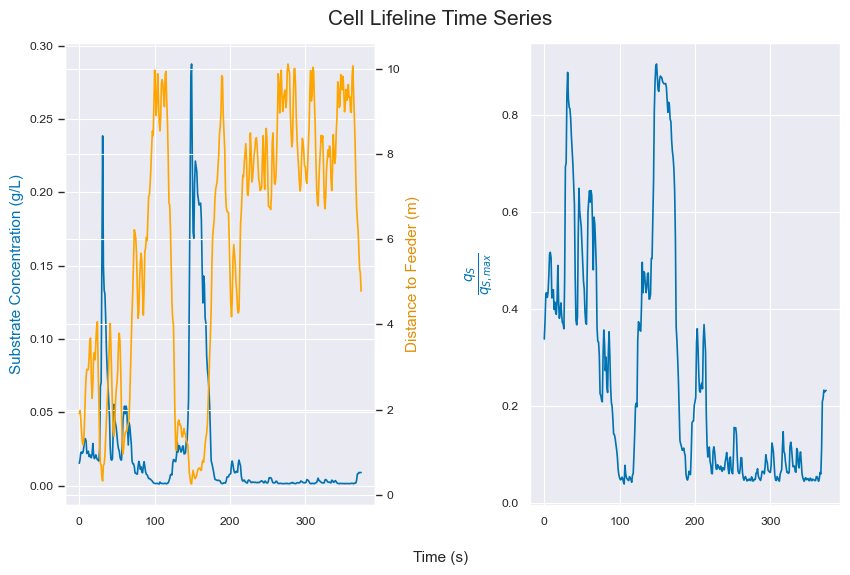

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Downsample and aggregate data
downsample_factor = 10
truncated_length = len(C_S_array) // downsample_factor * downsample_factor  # Truncate to a multiple of downsample_factor
truncated_time_array = time_array[:truncated_length]
truncated_C_S_array = C_S_array[:truncated_length]
aggregated_time_array = truncated_time_array[::downsample_factor]
aggregated_C_S_array = np.mean(truncated_C_S_array.reshape(-1, downsample_factor), axis=1)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Truncate dist_feed_point array to match the length of truncated_C_S_array
truncated_dist_feed_point = dist_feed_point[:truncated_length]

# Downsample and aggregate distance data
aggregated_dist_feed_point = np.mean(truncated_dist_feed_point.reshape(-1, downsample_factor), axis=1)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=aggregated_time_array, y=aggregated_C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11, color=sns.color_palette()[0])

# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=aggregated_time_array, y=aggregated_dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11, color=sns.color_palette()[1])

# Compute qS/qSmax
q_S = q_S_max * aggregated_C_S_array / (K_S + aggregated_C_S_array)
qS_qSmax = q_S / q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

sns.lineplot(x=aggregated_time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14, color=sns.color_palette()[0])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


In [14]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=aggregated_time_array)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0, len(aggregated_time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=aggregated_C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[aggregated_time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)

# Include Error as a new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as a CSV file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes_agg.csv", sep="\t", header=True, index=True)

100%|██████████| 375/375 [02:10<00:00,  2.86it/s]


Data Visualization

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
fluxes_df = pd.read_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", index_col=0)

# Filtering reactions
# Select subset of equidistant time points
# equidistant_time_points = [0, 10, 20, 30, 40]  # Example equidistant time points to select
# filtered_fluxes_df = fluxes_df.iloc[equidistant_time_points]

# Remove reactions with constant values over time
non_constant_fluxes_df = fluxes_df.loc[:, (fluxes_df != fluxes_df.iloc[0]).any()]
removed_constant_reactions = len(fluxes_df.columns) - len(non_constant_fluxes_df.columns)
print("Number of reactions removed due to constant values over time:", removed_constant_reactions)

# Eliminate transport and exchange reactions
# non_transport_exchange_fluxes_df = non_constant_fluxes_df[~non_constant_fluxes_df.index.str.contains("transport|exchange", case=False)]
# removed_transport_exchange_reactions = len(non_constant_fluxes_df.index) - len(non_transport_exchange_fluxes_df.index)
# print("Number of transport and exchange reactions removed:", removed_transport_exchange_reactions)

# Remove redundant reactions, keep one representative for coupled reactions
unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
removed_redundant_reactions = len(non_constant_fluxes_df.columns) - len(unique_reactions_fluxes_df.columns)
print("Number of redundant reactions removed:", removed_redundant_reactions)

# Calculate the correlation matrix
# corr_matrix = unique_reactions_fluxes_df.transpose().corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", square=True)
# plt.title("Correlation Matrix of Reaction Fluxes")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.show()


Number of reactions removed due to constant values over time: 49
Number of redundant reactions removed: 0


# Establishing Autoencoder

Reshaping so we reduce matrix size accordingly (3756,96,1) goes to (3756,10)

In [3]:
import optuna
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split

c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
fluxes_df

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,SUCCt2_2,SUCCt3,SUCDi,SUCOAS,TALA,THD2,TKT1,TKT2,TPI,Error
Time (s),,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.1,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.2,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.3,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.4,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375.1,0.0,0.0,0.0,0.950241,0.950241,0.0,0.0,0.950241,0.0,0.0,...,0.0,0.0,0.950241,-0.950241,0.040208,0.0,-0.020104,0.040208,0.485173,6.031235e-02
375.2,0.0,0.0,0.0,0.981516,0.981516,0.0,0.0,0.978212,0.0,0.0,...,0.0,0.0,0.978212,-0.978212,-0.000548,0.0,-0.000548,-0.001654,0.509334,-2.675166e-15
375.3,0.0,0.0,0.0,1.001194,1.001194,0.0,0.0,0.995020,0.0,0.0,...,0.0,0.0,0.995020,-0.995020,-0.001024,0.0,-0.001024,-0.003090,0.535305,-7.230179e-16


In [5]:
unique_reactions_fluxes_df

,ACONTa,ACONTb,AKGDH,ATPS4r,Biomass_Ecoli_core,CO2t,CS,CYTBD,ENO,EX_co2_e,...,PYK,RPE,RPI,SUCDi,SUCOAS,TALA,TKT1,TKT2,TPI,Error
Time (s),,,,,,,,,,,,,,,,,,,,,
0.0,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.1,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.2,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.3,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.4,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375.1,0.950241,0.950241,0.950241,6.429205,1.506328e-17,-2.850723,0.950241,5.701447,0.950241,2.850723,...,0.545485,0.020104,0.020104,0.950241,-0.950241,0.040208,-0.020104,0.040208,0.485173,6.031235e-02
375.2,0.981516,0.981516,0.978212,6.599177,3.062713e-03,-2.943946,0.981516,5.880810,1.012037,2.943946,...,0.489290,-0.002201,-0.002201,0.978212,-0.978212,-0.000548,-0.000548,-0.001654,0.509334,-2.675166e-15
375.3,1.001194,1.001194,0.995020,6.709377,5.722566e-03,-3.002458,1.001194,5.991683,1.058221,3.002458,...,0.497855,-0.004113,-0.004113,0.995020,-0.995020,-0.001024,-0.001024,-0.003090,0.535305,-7.230179e-16


In [6]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler

# Convert the DataFrame to a numpy array
data = unique_reactions_fluxes_df.to_numpy()

# Normalize the data feature-wise
scaler = StandardScaler()
normalized_data_2d = scaler.fit_transform(data)
normalized_data = normalized_data_2d.reshape(normalized_data_2d.shape[0], normalized_data_2d.shape[1], 1)

original_data = normalized_data

# Define the input layer
inp = Input(shape=(original_data.shape[1], original_data.shape[2]))

# Encoder layers
encoder = LSTM(100, activation='tanh', return_sequences=False, kernel_initializer='glorot_uniform')(inp)
latent = Dense(40, activation='tanh')(encoder)

# Decoder layers
repeated_latent = RepeatVector(original_data.shape[1])(latent)
decoder = LSTM(100, activation='tanh', return_sequences=True)(repeated_latent)
output = LSTM(original_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# Capture the initial weights
initial_weights = autoencoder.get_weights()

In [7]:
# DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_index, val_index in tscv.split(original_data):
    # Split data
    train, val = original_data[train_index], original_data[val_index]
    
    # Create data generators for this fold
    train_gen = DataGenerator(train, batch_size=32, shuffle=True)
    val_gen = DataGenerator(val, batch_size=32)
    
    # Uncomment the next line if you want to reset weights for each fold
    # autoencoder.set_weights(initial_weights)

    # Fit the autoencoder for this fold using the generators
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[reduce_lr, early_stop])


Epoch 1/50
20/20 [==============================] - 8s 157ms/step - loss: 1.2958 - val_loss: 0.5727 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 2s 124ms/step - loss: 1.2119 - val_loss: 0.5086 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 2s 125ms/step - loss: 1.1692 - val_loss: 0.4961 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 2s 122ms/step - loss: 1.1315 - val_loss: 0.4684 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 3s 128ms/step - loss: 1.0985 - val_loss: 0.4601 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 2s 117ms/step - loss: 1.0854 - val_loss: 0.4623 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 2s 119ms/step - loss: 1.0589 - val_loss: 0.4586 - lr: 0.0010
Epoch 8/50
20/20 [==============================] - 2s 123ms/step - loss: 1.0440 - val_loss: 0.4567 - lr: 0.0010
Epoch 9/50
20/20 [==============================] - 2s 124ms/step - loss: 1.0267 - val_loss: 0.4

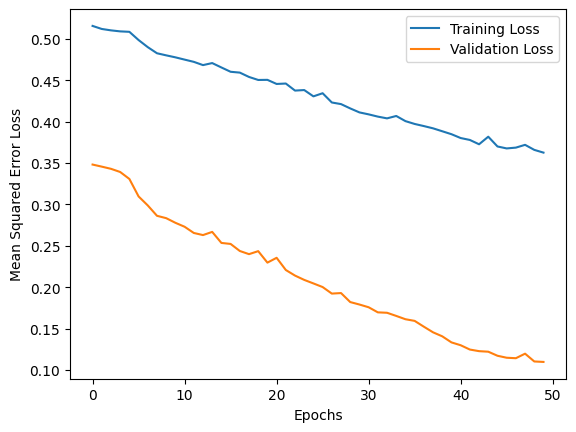

In [8]:
# Optional: Plot the training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(original_data, test_size=0.2, random_state=42)

encoder_model = Model(inputs=inp, outputs=latent)
latent_data = encoder_model.predict(test_data) # Predict the latent data for test set
reconstructed_data = autoencoder.predict(test_data) # Predict the reconstructed data for test set


24/24 [==============================] - 2s 31ms/step


Data Visualization

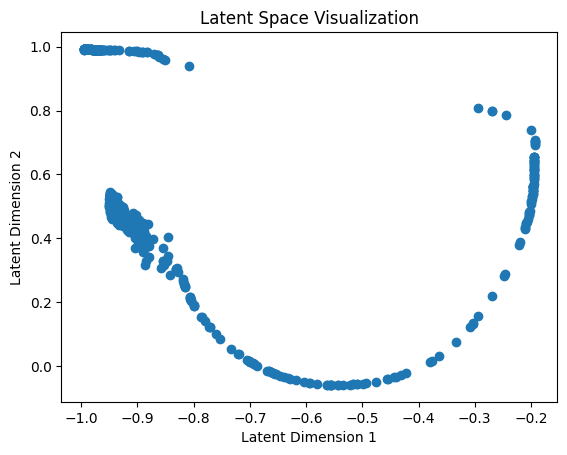

118/118 [==============================] - 4s 33ms/step
Loss Difference: 0.3068870642307307


In [10]:
import matplotlib.pyplot as plt

# Visualize the latent space
plt.scatter(latent_data[:, 0], latent_data[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# Compute the loss difference
reconstructed_data = autoencoder.predict(original_data )
loss_difference = np.mean(np.abs(reconstructed_data - original_data ))

print("Loss Difference:", loss_difference)


In [11]:
# Get the shapes of the original data and latent space
original_shape = original_data .shape
latent_shape = latent_data.shape

# Compare the sizes of the original data and latent space
print("Original Data Shape:", original_shape)
print("Latent Space Shape:", latent_shape)

# Compute the reduction percentage
original_data_points = original_shape[0] * original_shape[1]
latent_data_points = latent_shape[0] * latent_shape[1]
reduction_percentage = 100 - (latent_data_points / original_data_points) * 100
#reduction_percentage = (latent_shape[1] / original_shape[1]) * 100
print("Reduction Percentage:", reduction_percentage)


Original Data Shape: (3756, 47, 1)
Latent Space Shape: (752, 40)
Reduction Percentage: 82.96059637912673


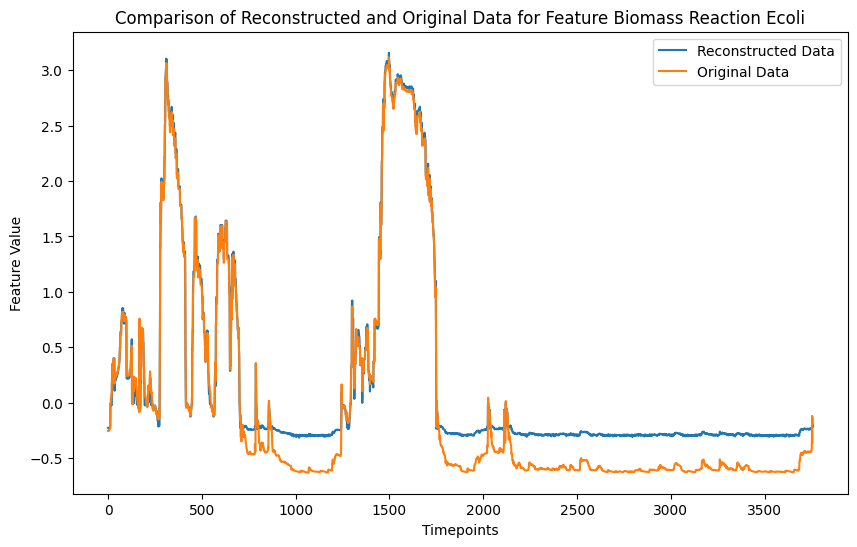

In [12]:
# Select a random feature for comparison
feature_index = np.random.randint(low=0, high=original_data.shape[1])
feature_index = 6

# Extract this feature across all samples from the original data
original_feature_values = original_data[:, feature_index]

# Extract the same feature from the reconstructed data
reconstructed_feature_values = reconstructed_data[:, feature_index, 0]  # Accessing the 0th index because the reconstructed data is 3-dimensional

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values, label='Reconstructed Data')

# Plot the original values for this feature
plt.plot(original_feature_values, label='Original Data')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value')
plt.title(f'Comparison of Reconstructed and Original Data for Feature Biomass Reaction Ecoli')
plt.legend()
plt.show()


In [1]:
from sklearn.cluster import KMeans

# Perform clustering on the latent space
kmeans = KMeans(n_clusters=3)  # Specify the desired number of clusters
clusters = kmeans.fit_predict(latent_data)

# Visualize the clusters
plt.scatter(latent_data[:, 0], latent_data[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Clustering in Latent Space')
plt.show()


NameError: name 'latent_data' is not defined

In [21]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 40)                4040      
                                                                 
 repeat_vector (RepeatVecto  (None, 47, 40)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 47, 100)           56400     
                                                                 
 lstm_2 (LSTM)               (None, 47, 1)             408       
                                                             

In [23]:
# Get the weights from encoder LSTM to the latent space
encoder_to_latent_weights = autoencoder.layers[1].get_weights()[0]

# Get the weights from latent space to the decoder LSTM
latent_to_decoder_weights = autoencoder.layers[2].get_weights()[0]

# Compute the feature importance
encoder_importance = np.mean(np.abs(encoder_to_latent_weights), axis=0)
decoder_importance = np.mean(np.abs(latent_to_decoder_weights), axis=1)

# Sort the features based on importance
sorted_indices = np.argsort(decoder_importance)[::-1]
sorted_importance = decoder_importance[sorted_indices]

# Print the sorted features and their importance
for i, index in enumerate(sorted_indices):
    print(f"Feature {index+1}: Importance = {sorted_importance[i]}")


Feature 70: Importance = 0.14315228164196014
Feature 26: Importance = 0.13554523885250092
Feature 72: Importance = 0.13542383909225464
Feature 94: Importance = 0.1328931301832199
Feature 62: Importance = 0.12845607101917267
Feature 14: Importance = 0.12826678156852722
Feature 77: Importance = 0.1273692548274994
Feature 99: Importance = 0.1268821805715561
Feature 75: Importance = 0.12628118693828583
Feature 81: Importance = 0.12574392557144165
Feature 32: Importance = 0.12466921657323837
Feature 35: Importance = 0.12367293983697891
Feature 4: Importance = 0.12221453338861465
Feature 41: Importance = 0.12196043878793716
Feature 53: Importance = 0.11962233483791351
Feature 64: Importance = 0.11957623809576035
Feature 97: Importance = 0.11953248083591461
Feature 31: Importance = 0.11918427795171738
Feature 23: Importance = 0.11868184804916382
Feature 55: Importance = 0.11844336986541748
Feature 30: Importance = 0.11828503757715225
Feature 60: Importance = 0.11764669418334961
Feature 68: Im

Save data to run in R for clustering + random forest classification

In [25]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data.csv", index=False)


# Hyperparameter Tuning 
Needs to be worked on (did not update from previous weeks)

In [24]:
import optuna
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split

In [25]:
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from keras.optimizers import RMSprop, Adam


# Convert the DataFrame to a numpy array
data = fluxes_df.to_numpy()

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Before any processing
original_data = normalized_data.copy()

# Reshape the normalized data for the LSTM
reshaped_data = normalized_data.reshape(normalized_data.shape[0], normalized_data.shape[1], 1)
# Objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to optimize and their search spaces
    lstm_units = trial.suggest_int('lstm_units', 5, 100)
    latent_units = trial.suggest_int('latent_units', 5, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    activation_fn = trial.suggest_categorical('activation_fn', ['tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    rmse = []

    for train_index, test_index in tscv.split(reshaped_data):
        # Split the data into train and validation sets
        train_data, val_data = reshaped_data[train_index], reshaped_data[test_index]

        # Define the input layer
        inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

        # Encoder layers
        encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
        latent = Dense(latent_units, activation=activation_fn)(encoder)

        # Decoder layers
        repeated_latent = RepeatVector(train_data.shape[1])(latent)
        decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
        output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

        # Create the autoencoder model
        autoencoder = Model(inputs=inp, outputs=output)
        optimizer = Adam(learning_rate=learning_rate)
        autoencoder.compile(optimizer=optimizer, loss='mse')

        # Initialize the data generator
        train_gen = DataGenerator(train_data, batch_size=batch_size)

        # Train the autoencoder using the generator
        autoencoder.fit(train_gen, epochs=20)

        # Get the reduced-dimensional representation (latent space)
        encoder_model = Model(inputs=inp, outputs=latent)
        latent_data = encoder_model.predict(val_data)

        # Calculate a suitable metric for evaluation (e.g., reconstruction loss)
        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_data)))

        rmse.append(reconstruction_loss)

    return np.mean(rmse)

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute the number of batches
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Get the indices for this batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Fetch the normalized data for these indices
        batch_data = self.data[batch_indices]
        
        return batch_data, batch_data  # Because you're using an autoencoder, input and output are the same.

    def on_epoch_end(self):
        # Shuffle the indices for the next epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [26]:
study = optuna.create_study(direction='minimize')  # Create a new study with minimization as the goal
study.optimize(objective, n_trials=3)  # Invoke optimization of the objective function

[I 2023-10-09 01:48:04,299] A new study created in memory with name: no-name-9e2b67ba-d021-41c1-b729-26d2ba9db6d7


Epoch 1/20
24/24 [==============================] - 6s 97ms/step - loss: 0.6271
Epoch 2/20
24/24 [==============================] - 2s 101ms/step - loss: 0.6261
Epoch 3/20
24/24 [==============================] - 2s 98ms/step - loss: 0.6253
Epoch 4/20
24/24 [==============================] - 2s 98ms/step - loss: 0.6246
Epoch 5/20
24/24 [==============================] - 2s 102ms/step - loss: 0.6239
Epoch 6/20
24/24 [==============================] - 2s 97ms/step - loss: 0.6231
Epoch 7/20
24/24 [==============================] - 3s 104ms/step - loss: 0.6224
Epoch 8/20
24/24 [==============================] - 2s 102ms/step - loss: 0.6216
Epoch 9/20
24/24 [==============================] - 3s 105ms/step - loss: 0.6206
Epoch 10/20
24/24 [==============================] - 3s 105ms/step - loss: 0.6199
Epoch 11/20
24/24 [==============================] - 2s 100ms/step - loss: 0.6188
Epoch 12/20
24/24 [==============================] - 2s 103ms/step - loss: 0.6178
Epoch 13/20
24/24 [==========

[I 2023-10-09 01:56:14,943] Trial 0 finished with value: 0.44686960050373853 and parameters: {'lstm_units': 53, 'latent_units': 32, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 3.547621350625713e-05}. Best is trial 0 with value: 0.44686960050373853.


Epoch 1/20
24/24 [==============================] - 7s 112ms/step - loss: 525.0458
Epoch 2/20
24/24 [==============================] - 3s 116ms/step - loss: 0.6465
Epoch 3/20
24/24 [==============================] - 3s 114ms/step - loss: 0.6315
Epoch 4/20
24/24 [==============================] - 3s 111ms/step - loss: 0.6284
Epoch 5/20
24/24 [==============================] - 3s 110ms/step - loss: 0.6286
Epoch 6/20
24/24 [==============================] - 3s 112ms/step - loss: 0.6262
Epoch 7/20
24/24 [==============================] - 3s 109ms/step - loss: 0.6248
Epoch 8/20
24/24 [==============================] - 3s 112ms/step - loss: 0.6225
Epoch 9/20
24/24 [==============================] - 3s 119ms/step - loss: 0.6209
Epoch 10/20
24/24 [==============================] - 3s 120ms/step - loss: 0.6192
Epoch 11/20
24/24 [==============================] - 3s 110ms/step - loss: 0.6166
Epoch 12/20
24/24 [==============================] - 3s 113ms/step - loss: 0.6141
Epoch 13/20
24/24 [====

[I 2023-10-09 02:06:28,646] Trial 1 finished with value: 0.45781516619231283 and parameters: {'lstm_units': 95, 'latent_units': 95, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 0.008655334136955474}. Best is trial 0 with value: 0.44686960050373853.


Epoch 1/20
12/12 [==============================] - 6s 114ms/step - loss: 10250.2393
Epoch 2/20
12/12 [==============================] - 1s 91ms/step - loss: 0.6338
Epoch 3/20
12/12 [==============================] - 1s 90ms/step - loss: 0.6300
Epoch 4/20
12/12 [==============================] - 1s 95ms/step - loss: 0.6288
Epoch 5/20
12/12 [==============================] - 1s 86ms/step - loss: 0.6284
Epoch 6/20
12/12 [==============================] - 1s 102ms/step - loss: 0.6284
Epoch 7/20
12/12 [==============================] - 1s 89ms/step - loss: 0.6283
Epoch 8/20
12/12 [==============================] - 1s 88ms/step - loss: 0.6283
Epoch 9/20
12/12 [==============================] - 1s 93ms/step - loss: 0.6283
Epoch 10/20
12/12 [==============================] - 1s 110ms/step - loss: 0.6283
Epoch 11/20
12/12 [==============================] - 1s 86ms/step - loss: 0.6283
Epoch 12/20
12/12 [==============================] - 1s 88ms/step - loss: 0.6283
Epoch 13/20
12/12 [===========

[W 2023-10-09 02:09:33,771] Trial 2 failed with parameters: {'lstm_units': 42, 'latent_units': 77, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 0.007501519304923438} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\elysi\AppData\Local\Temp\ipykernel_30000\3810731168.py", line 61, in objective
    autoencoder.fit(train_gen, epochs=20)
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
    tmp_logs = self.train_function(iterator)
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-pack

KeyboardInterrupt: 

In [80]:
# After optimizing with Optuna
best_params = study.best_params
print(best_params)

{'lstm_units': 56, 'latent_units': 7, 'batch_size': 16, 'activation_fn': 'tanh', 'learning_rate': 6.332406429519958e-05}


In [81]:
import numpy as np
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.optimizers import Adam
import json

train_data = reshaped_data  

# Use the best parameters from Optuna optimization in your model
lstm_units = best_params['lstm_units']
latent_units = best_params['latent_units']
batch_size = best_params['batch_size']
activation_fn = best_params['activation_fn']
learning_rate = best_params['learning_rate']

# Define the autoencoder model with best hyperparameters
inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

# Encoder layers
encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
latent = Dense(latent_units, activation=activation_fn)(encoder)

# Decoder layers
repeated_latent = RepeatVector(train_data.shape[1])(latent)
decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create and compile the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Train the autoencoder using the generator
train_gen = DataGenerator(train_data, batch_size=batch_size)
autoencoder.fit(train_gen, epochs=20)


Epoch 1/20
235/235 [==============================] - 20s 70ms/step - loss: 0.4885
Epoch 2/20
235/235 [==============================] - 18s 75ms/step - loss: 0.4810
Epoch 3/20
235/235 [==============================] - 17s 70ms/step - loss: 0.4711
Epoch 4/20
235/235 [==============================] - 14s 61ms/step - loss: 0.4575
Epoch 5/20
235/235 [==============================] - 14s 61ms/step - loss: 0.4542
Epoch 6/20
235/235 [==============================] - 15s 65ms/step - loss: 0.4536
Epoch 7/20
235/235 [==============================] - 15s 64ms/step - loss: 0.4531
Epoch 8/20
235/235 [==============================] - 14s 62ms/step - loss: 0.4526
Epoch 9/20
235/235 [==============================] - 15s 65ms/step - loss: 0.4528
Epoch 10/20
235/235 [==============================] - 15s 65ms/step - loss: 0.4520
Epoch 11/20
235/235 [==============================] - 15s 64ms/step - loss: 0.4515
Epoch 12/20
235/235 [==============================] - 15s 64ms/step - loss: 0.4486
E

118/118 [==============================] - 4s 34ms/step


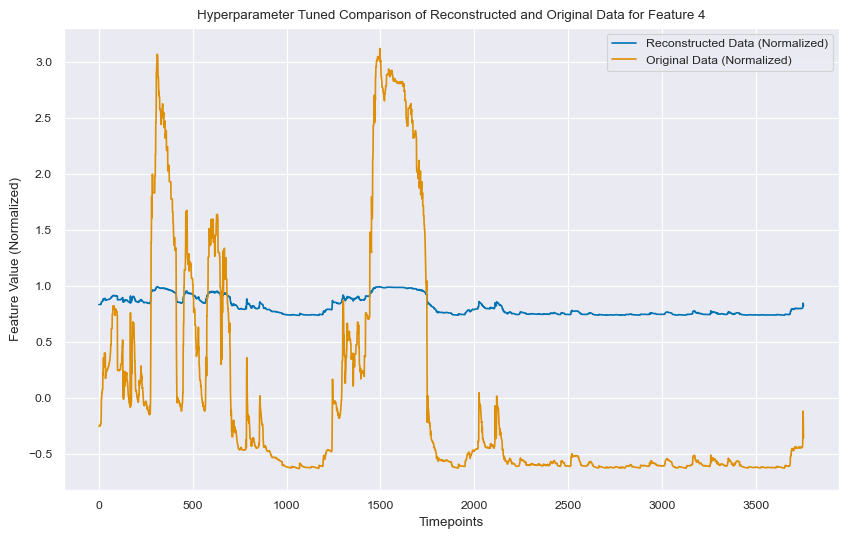

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_data is your original_data
original_data = train_data

# Use the trained autoencoder to reconstruct the data
reconstructed_data = autoencoder.predict(train_data)

# Normalize the original data using the scaler from the DataGenerator
original_data_normalized = train_gen.scaler.transform(original_data.reshape(original_data.shape[0], -1)).reshape(original_data.shape)

# Select a random feature for comparison
#feature_index = np.random.randint(low=0, high=original_data_normalized.shape[1])
feature_index = 4

# Extract this feature across all samples from the original data and ensure its shape is compatible for comparison
original_feature_values_normalized = original_data_normalized[:, feature_index, 0]

# Extract the same feature from the reconstructed (and normalized) data
reconstructed_feature_values = reconstructed_data[:, feature_index, 0]  # Accessing the 0th index because the reconstructed data is 3-dimensional

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values, label='Reconstructed Data (Normalized)')

# Plot the original values for this feature
plt.plot(original_feature_values_normalized, label='Original Data (Normalized)')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value (Normalized)')
plt.title(f'Hyperparameter Tuned Comparison of Reconstructed and Original Data for Feature {feature_index}')
plt.legend()
plt.show()


In [87]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)


Best Hyperparameters: {'lstm_units': 56, 'latent_units': 7, 'batch_size': 16, 'activation_fn': 'tanh', 'learning_rate': 6.332406429519958e-05}
Best Loss: 2.331437143752819


In [ ]:
# Get the latent space representations
latent_data = encoder_model.predict(reshaped_data)

# Perform regression analysis
reg_model = LinearRegression()
reg_model.fit(latent_data, target_variable)
reg_predictions = reg_model.predict(latent_data)

# Perform k-nearest neighbors analysis
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(latent_data, target_variable)
knn_predictions = knn_model.predict(latent_data)

# Visualize the results
plt.scatter(latent_data, target_variable, label='Actual')
plt.plot(latent_data, reg_predictions, label='Regression Predictions')
plt.plot(latent_data, knn_predictions, label='k-NN Predictions')
plt.xlabel('Latent Space')
plt.ylabel('Target Variable')
plt.title('Regression and k-NN Predictions in Latent Space')
plt.legend()
plt.show()

## Regularized Autoencoders

In [89]:
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization


# Convert the DataFrame to a numpy array
data = fluxes_df.to_numpy()

# Reshape the data for the LSTM
reshaped_data = data.reshape(data.shape[0], data.shape[1], 1)

# Objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to optimize and their search spaces
    lstm_units = trial.suggest_int('lstm_units', 5, 100)
    latent_units = trial.suggest_int('latent_units', 5, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    activation_fn = trial.suggest_categorical('activation_fn', ['tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    rmse = []

    for train_index, test_index in tscv.split(reshaped_data):
        # Split the data into train and validation sets
        train_data, val_data = reshaped_data[train_index], reshaped_data[test_index]

        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
        # Define the input layer
        inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

        # Encoder layers with Dropout and BatchNormalization
        encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
        encoder = Dropout(dropout_rate)(encoder)
        encoder = BatchNormalization()(encoder)
        latent = Dense(latent_units, activation=activation_fn)(encoder)

        # Decoder layers with Dropout and BatchNormalization
        repeated_latent = RepeatVector(train_data.shape[1])(latent)
        decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
        decoder = Dropout(dropout_rate)(decoder)
        decoder = BatchNormalization()(decoder)
        output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

        # Create the autoencoder model
        autoencoder = Model(inputs=inp, outputs=output)
        optimizer = Adam(learning_rate=learning_rate)
        autoencoder.compile(optimizer=optimizer, loss='mse')

        # Initialize the data generator
        train_gen = DataGenerator(train_data, batch_size=batch_size)

        # Train the autoencoder using the generator
        autoencoder.fit(train_gen, epochs=20)

        # Get the reduced-dimensional representation (latent space)
        encoder_model = Model(inputs=inp, outputs=latent)
        latent_data = encoder_model.predict(val_data)

        # Calculate a suitable metric for evaluation (e.g., reconstruction loss)
        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_data)))

        rmse.append(reconstruction_loss)

    return np.mean(rmse)

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        # Normalize the data

        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(data.reshape(data.shape[0], -1)).reshape(data.shape)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute the number of batches
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Get the indices for this batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Fetch the normalized data for these indices
        batch_data = self.data[batch_indices]
        
        return batch_data, batch_data  # Because you're using an autoencoder, input and output are the same.

    def on_epoch_end(self):
        # Shuffle the indices for the next epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [91]:
study = optuna.create_study(direction='minimize')  # Create a new study with minimization as the goal
study.optimize(objective, n_trials=2)  # Invoke optimization of the objective function

[I 2023-09-25 19:09:55,008] A new study created in memory with name: no-name-4cc96b34-b906-4c80-9213-886c032f9665


Epoch 1/20
24/24 [==============================] - 9s 120ms/step - loss: 0.8122
Epoch 2/20
24/24 [==============================] - 3s 122ms/step - loss: 0.6387
Epoch 3/20
24/24 [==============================] - 3s 120ms/step - loss: 0.6015
Epoch 4/20
24/24 [==============================] - 3s 110ms/step - loss: 0.5818
Epoch 5/20
24/24 [==============================] - 3s 112ms/step - loss: 0.5616
Epoch 6/20
24/24 [==============================] - 3s 112ms/step - loss: 0.5473
Epoch 7/20
24/24 [==============================] - 3s 128ms/step - loss: 0.5361
Epoch 8/20
24/24 [==============================] - 3s 106ms/step - loss: 0.5214
Epoch 9/20
24/24 [==============================] - 3s 107ms/step - loss: 0.5136
Epoch 10/20
24/24 [==============================] - 3s 108ms/step - loss: 0.5094
Epoch 11/20
24/24 [==============================] - 3s 118ms/step - loss: 0.5068
Epoch 12/20
24/24 [==============================] - 3s 114ms/step - loss: 0.5022
Epoch 13/20
24/24 [======

[I 2023-09-25 19:19:30,873] Trial 0 finished with value: 2.7233981558388383 and parameters: {'lstm_units': 84, 'latent_units': 48, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 0.0001607963329695215, 'dropout_rate': 0.4364263847969744}. Best is trial 0 with value: 2.7233981558388383.


Epoch 1/20
12/12 [==============================] - 6s 120ms/step - loss: 7.7051
Epoch 2/20
12/12 [==============================] - 1s 124ms/step - loss: 6.4634
Epoch 3/20
12/12 [==============================] - 1s 123ms/step - loss: 7.3113
Epoch 4/20
12/12 [==============================] - 2s 125ms/step - loss: 5.5256
Epoch 5/20
12/12 [==============================] - 2s 126ms/step - loss: 5.1404
Epoch 6/20
12/12 [==============================] - 1s 120ms/step - loss: 4.8067
Epoch 7/20
12/12 [==============================] - 1s 122ms/step - loss: 4.4402
Epoch 8/20
12/12 [==============================] - 2s 126ms/step - loss: 4.7458
Epoch 9/20
12/12 [==============================] - 2s 126ms/step - loss: 4.4140
Epoch 10/20
12/12 [==============================] - 1s 121ms/step - loss: 3.4299
Epoch 11/20
12/12 [==============================] - 1s 124ms/step - loss: 3.7241
Epoch 12/20
12/12 [==============================] - 2s 124ms/step - loss: 2.8690
Epoch 13/20
12/12 [======

[I 2023-09-25 19:25:07,871] Trial 1 finished with value: 4.526488396405549 and parameters: {'lstm_units': 68, 'latent_units': 27, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 1.4879090633369935e-05, 'dropout_rate': 0.113181239019876}. Best is trial 0 with value: 2.7233981558388383.


In [92]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)


Best Hyperparameters: {'lstm_units': 84, 'latent_units': 48, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 0.0001607963329695215, 'dropout_rate': 0.4364263847969744}
Best Loss: 2.7233981558388383


In [93]:
import numpy as np
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import json

train_data = reshaped_data  

# Use the best parameters from Optuna optimization in your model
lstm_units = best_params['lstm_units']
latent_units = best_params['latent_units']
batch_size = best_params['batch_size']
activation_fn = best_params['activation_fn']
learning_rate = best_params['learning_rate']
dropout_rate = best_params.get('dropout_rate', 0.2)  # you can set a default dropout rate

# Define the autoencoder model with best hyperparameters
inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

# Encoder layers
encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
encoder = Dropout(dropout_rate)(encoder)  # added Dropout layer
encoder = BatchNormalization()(encoder)  # added BatchNormalization layer
latent = Dense(latent_units, activation=activation_fn)(encoder)

# Decoder layers
repeated_latent = RepeatVector(train_data.shape[1])(latent)
decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create and compile the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Train the autoencoder using the generator
train_gen = DataGenerator(train_data, batch_size=batch_size)
autoencoder.fit(train_gen, epochs=20)


Epoch 1/20
118/118 [==============================] - 24s 156ms/step - loss: 0.4938
Epoch 2/20
118/118 [==============================] - 19s 163ms/step - loss: 0.4883
Epoch 3/20
118/118 [==============================] - 19s 161ms/step - loss: 0.4863
Epoch 4/20
118/118 [==============================] - 18s 153ms/step - loss: 0.4840
Epoch 5/20
118/118 [==============================] - 18s 155ms/step - loss: 0.4810
Epoch 6/20
118/118 [==============================] - 18s 152ms/step - loss: 0.4790
Epoch 7/20
118/118 [==============================] - 18s 156ms/step - loss: 0.4773
Epoch 8/20
118/118 [==============================] - 20s 169ms/step - loss: 0.4763
Epoch 9/20
118/118 [==============================] - 17s 148ms/step - loss: 0.4753
Epoch 10/20
118/118 [==============================] - 18s 154ms/step - loss: 0.4742
Epoch 11/20
118/118 [==============================] - 19s 160ms/step - loss: 0.4733
Epoch 12/20
118/118 [==============================] - 18s 151ms/step - lo

118/118 [==============================] - 7s 51ms/step


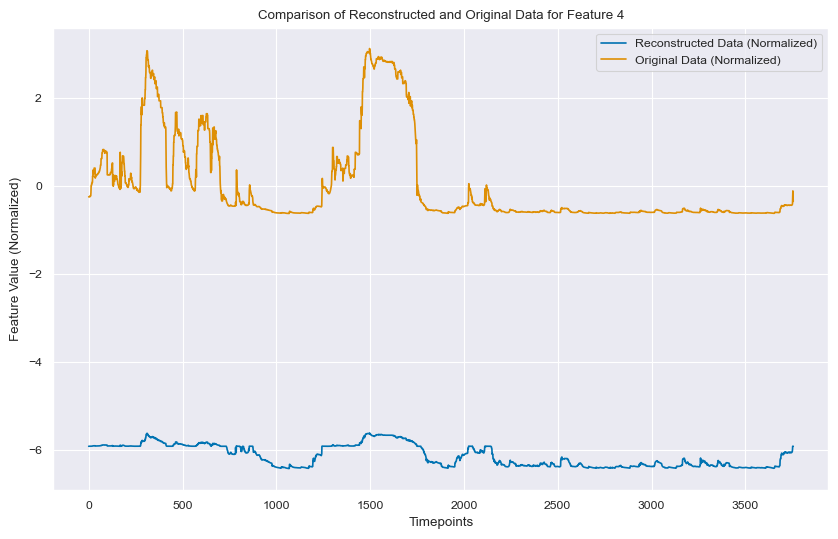

In [94]:
# Assuming train_data is your original_data
original_data = train_data

# Use the trained autoencoder to reconstruct the data
reconstructed_data = autoencoder.predict(train_data)

# Normalize the original and reconstructed data using the scaler from the DataGenerator
# We're using train_gen.scaler.transform to ensure the data is on the same scale
original_data_normalized = train_gen.scaler.transform(original_data.reshape(original_data.shape[0], -1)).reshape(original_data.shape)
reconstructed_data_normalized = train_gen.scaler.transform(reconstructed_data.reshape(reconstructed_data.shape[0], -1)).reshape(reconstructed_data.shape)

# Select a random feature for comparison
feature_index = 4  # or use np.random.randint to select a random index

# Extract this feature across all samples from the original and reconstructed data and ensure its shape is compatible for comparison
original_feature_values_normalized = original_data_normalized[:, feature_index, 0]
reconstructed_feature_values_normalized = reconstructed_data_normalized[:, feature_index, 0]

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values_normalized, label='Reconstructed Data (Normalized)')

# Plot the original values for this feature
plt.plot(original_feature_values_normalized, label='Original Data (Normalized)')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value (Normalized)')
plt.title(f'Comparison of Reconstructed and Original Data for Feature {feature_index}')
plt.legend()
plt.show()


## Training on multiple lifelines

In [1]:
import os
import numpy as np
import pandas as pd

# Get the filenames of lifeline dataframes
folder_path = 'dFBA_Data_Frames_Lifelines'
file_names = sorted(os.listdir(folder_path))

# Load the time axis
time = np.arange(0, 3754 * 0.1, 0.1)

# Load the cell lifeline and reaction data
num_lifelines = len(file_names)
num_reactions = first_lifeline_df.shape[1] - 1

# Initialize data as a 3D matrix
data = np.empty((len(time), num_lifelines, num_reactions))

for i, file_name in enumerate(file_names):
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)  # Assuming the data is in CSV format
    
    # Assign lifeline_number based on the index i
    lifeline_number = i
    
    # Extract the reaction data
    reaction_data = lifeline_df.iloc[1:3755, 1:].to_numpy()  # Exclude the first column and limit to the length of time
    
    # Assign data to the corresponding dimensions
    data[:, lifeline_number, :] = reaction_data


# Print the shape of the big matrix
print("Shape of the Big Matrix:")
print(data.shape)

NameError: name 'first_lifeline_df' is not defined

In [35]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import optuna
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split


def objective(trial):
    # Define the hyperparameters to optimize and their search spaces
    hidden_units = trial.suggest_int('hidden_units', 10, 100)
    latent_units = trial.suggest_int('latent_units', 5, 75)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    rmse = []

    for train_index, test_index in tscv.split(data):
        # Split the data into train and validation sets
        train_data, val_data = data[train_index], data[test_index]

        # Define the input layer
        inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

        # Reshape the input to match desired dimensions
        reshaped_input = Reshape((train_data.shape[1] * train_data.shape[2],))(inp)

        # Encoder layers
        encoder = Dense(hidden_units, activation=activation)(reshaped_input)
        latent = Dense(latent_units, activation=activation)(encoder)

        # Decoder layers
        decoder = Dense(hidden_units, activation=activation)(latent)
        output = Dense(train_data.shape[1] * train_data.shape[2], activation='sigmoid')(decoder)

        # Reshape the output to match original dimensions
        reshaped_output = Reshape((train_data.shape[1], train_data.shape[2]))(output)

        # Create the autoencoder model
        autoencoder = Model(inputs=inp, outputs=reshaped_output)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Train the autoencoder on the training set
        autoencoder.fit(train_data, train_data, epochs=20, batch_size=32)

        # Get the reduced-dimensional representation (latent space)
        encoder_model = Model(inputs=inp, outputs=latent)
        latent_data = encoder_model.predict(val_data)

        # Calculate a suitable metric for evaluation (e.g., reconstruction loss)
        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_data)))

        rmse.append(reconstruction_loss)

    return np.mean(rmse)


In [36]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-06-23 19:34:39,637] A new study created in memory with name: no-name-f607e20a-587f-41ff-9911-95429bf0d320


Epoch 1/20
24/24 [==============================] - 1s 9ms/step - loss: 2.2687
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0241
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0238
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0237
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0236
Epoch 6/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0236
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0236
Epoch 8/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0236
Epoch 9/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0235
Epoch 10/20
24/24 [==============================] - 0s 12ms/step - loss: 2.0235
Epoch 11/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0235
Epoch 12/20
24/24 [==============================] - 0s 9ms/step - loss: 2.0235
Epoch 13/20
24/24 [=============================

[I 2023-06-23 19:35:30,530] Trial 0 finished with value: 2.0654344019890742 and parameters: {'hidden_units': 12, 'latent_units': 59, 'activation': 'relu', 'learning_rate': 0.00014139318236164016}. Best is trial 0 with value: 2.0654344019890742.


In [37]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'hidden_units': 12, 'latent_units': 59, 'activation': 'relu', 'learning_rate': 0.00014139318236164016}
Best Loss: 2.0654344019890742


In [45]:
import matplotlib.pyplot as plt

# Get the best hyperparameters from Optuna
best_params = study.best_params
hidden_units = best_params['hidden_units']
latent_units = best_params['latent_units']
activation = best_params['activation']

# Reshape the data for the autoencoder
reshaped_data = data

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Reshape the input to match desired dimensions
reshaped_input = Reshape((reshaped_data.shape[1] * reshaped_data.shape[2],))(inp)

# Encoder layers
encoder = Dense(hidden_units, activation=activation)(reshaped_input)
latent = Dense(latent_units, activation=activation)(encoder)

# Decoder layers
decoder = Dense(hidden_units, activation=activation)(latent)
output = Dense(reshaped_data.shape[1] * reshaped_data.shape[2], activation='sigmoid')(decoder)

# Reshape the output to match original dimensions
reshaped_output = Reshape((reshaped_data.shape[1], reshaped_data.shape[2]))(output)

# Create the autoencoder model with best hyperparameters
autoencoder = Model(inputs=inp, outputs=reshaped_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with best hyperparameters
autoencoder.fit(reshaped_data, reshaped_data, epochs=20, batch_size=32)

# Get the reconstructed data
reconstructed_data = autoencoder.predict(reshaped_data)

# Reshape the reconstructed data and original data for visualization
reconstructed_data = np.squeeze(reconstructed_data)
original_data = np.squeeze(reshaped_data)


Epoch 1/20
118/118 [==============================] - 2s 9ms/step - loss: 2.1063
Epoch 2/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0560
Epoch 3/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0559
Epoch 4/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0558
Epoch 5/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0558
Epoch 6/20
118/118 [==============================] - 1s 9ms/step - loss: 2.0557
Epoch 7/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0556
Epoch 8/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0555
Epoch 9/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0553
Epoch 10/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0547
Epoch 11/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0540
Epoch 12/20
118/118 [==============================] - 1s 8ms/step - loss: 2.0539
Epoch 13/20
118/118 [====

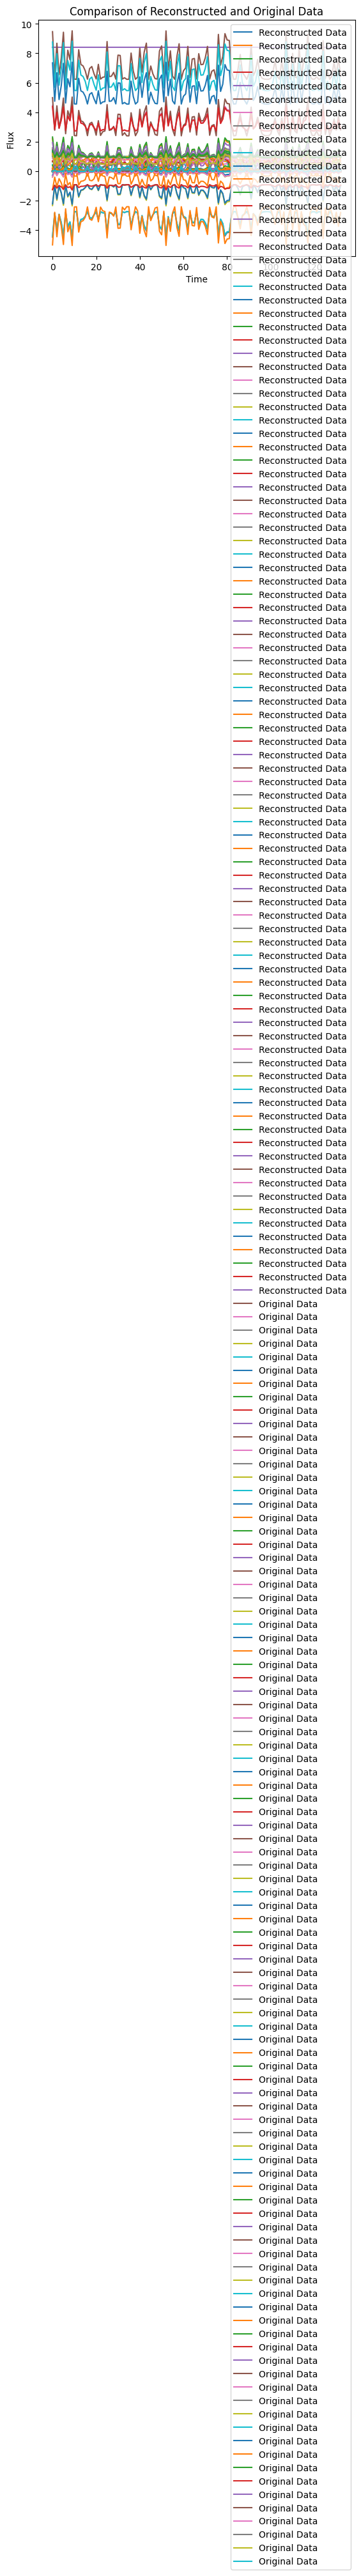

In [46]:
# Select a random sample from the data for comparison
sample_index = np.random.randint(low=0, high=original_data.shape[0])

# Plot the reconstructed data
plt.plot(reconstructed_data[sample_index], label='Reconstructed Data')

# Plot the original data
plt.plot(original_data[sample_index], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Reconstructed and Original Data')
plt.legend()
plt.show()

Using LSTM Autoencoders

In [46]:
from keras.layers import Input, Dense, LSTM, RepeatVector
from keras.models import Model

# Reshape the data for the autoencoder
reshaped_data = np.expand_dims(data, axis=2)

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Encoder layers
encoder = LSTM(50, activation='tanh', return_sequences=True)(inp)
latent = LSTM(10, activation='tanh')(encoder)

# Decoder layers
decoder = RepeatVector(reshaped_data.shape[1])(latent)
decoder = LSTM(50, activation='tanh', return_sequences=True)(decoder)
output = Dense(1, activation='sigmoid')(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(reshaped_data, reshaped_data, epochs=10, batch_size=32)

# Get the reduced-dimensional representation (latent space)
encoder = Model(inputs=inp, outputs=latent)
latent_data = encoder.predict(reshaped_data)

# Get the shapes of the original data and latent space
original_shape = reshaped_data.shape
latent_shape = latent_data.shape

# Compare the sizes of the original data and latent space
print("Original Data Shape:", original_shape)
print("Latent Space Shape:", latent_shape)

# Compute the reduction percentage
reduction_percentage = (original_shape[1] - latent_shape[1]) / original_shape[1] * 100
print("Reduction Percentage:", reduction_percentage)


Epoch 1/10
118/118 [==============================] - 28s 158ms/step - loss: 2.4538
Epoch 2/10
118/118 [==============================] - 19s 161ms/step - loss: 2.3599
Epoch 3/10
118/118 [==============================] - 21s 182ms/step - loss: 2.3387
Epoch 4/10
118/118 [==============================] - 22s 184ms/step - loss: 2.2931
Epoch 5/10
118/118 [==============================] - 22s 188ms/step - loss: 2.2093
Epoch 6/10
118/118 [==============================] - 22s 185ms/step - loss: 2.1934
Epoch 7/10
118/118 [==============================] - 19s 160ms/step - loss: 2.1863
Epoch 8/10
118/118 [==============================] - 18s 152ms/step - loss: 2.1833
Epoch 9/10
118/118 [==============================] - 20s 173ms/step - loss: 2.1950
Epoch 10/10
118/118 [==============================] - 8s 48ms/step
Original Data Shape: (3756, 96, 1)
Latent Space Shape: (3756, 10)
Reduction Percentage: 89.58333333333334


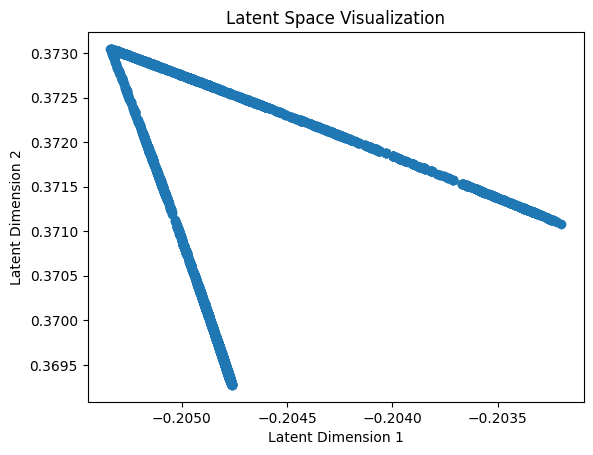

118/118 [==============================] - 9s 54ms/step
Loss Difference: 0.6668439625084274


In [47]:
import matplotlib.pyplot as plt

# Visualize the latent space
plt.scatter(latent_data[:, 0], latent_data[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# Compute the loss difference
reconstructed_data = autoencoder.predict(reshaped_data)
loss_difference = np.mean(np.abs(reconstructed_data - reshaped_data))

print("Loss Difference:", loss_difference)


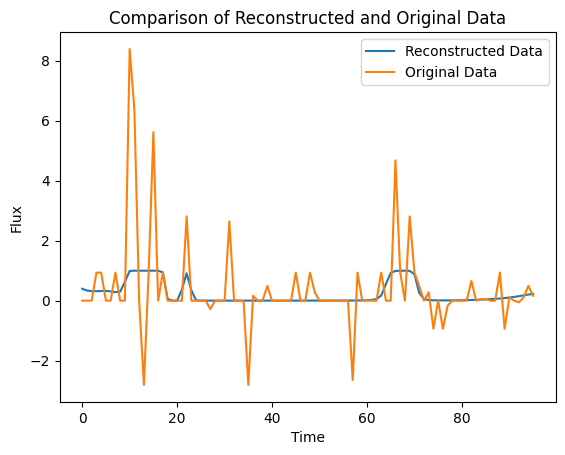

In [48]:
import matplotlib.pyplot as plt

# Reshape the reconstructed data and original data for visualization
reconstructed_data = np.squeeze(reconstructed_data)
original_data = np.squeeze(reshaped_data)

# Select a random sample from the data for comparison
sample_index = np.random.randint(low=0, high=original_data.shape[0])

# Plot the reconstructed data
plt.plot(reconstructed_data[sample_index], label='Reconstructed Data')

# Plot the original data
plt.plot(original_data[sample_index], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Reconstructed and Original Data')
plt.legend()
plt.show()


# Working - Current Autoencoder Model 
Checking matrix dimensions should be 3754 x 133 x 95 to reduced size
Necessity of hidden units 
Add hidden layers to further optimize 

In [2]:
import os
import numpy as np
import pandas as pd

class DataLoader:
    def __init__(self, folder_path):
        self.folder_path = folder_path
    
    def load_data(self):
        # Load the time axis
        time = np.arange(0, 3754 * 0.1, 0.1)
        
        file_names = sorted(os.listdir(self.folder_path))
        num_lifelines = len(file_names)

        # Assuming first_lifeline_df is defined
        first_lifeline_df = pd.read_csv(os.path.join(self.folder_path, file_names[0]), sep="\t", index_col=0)
        num_reactions = first_lifeline_df.shape[1] - 1

        data = np.empty((len(time), num_lifelines, num_reactions))

        for i, file_name in enumerate(file_names):
            file_path = os.path.join(self.folder_path, file_name)
            lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)  # Assuming the data is in CSV format

            # Assign lifeline_number based on the index i
            lifeline_number = i

            # Extract the reaction data
            reaction_data = lifeline_df.iloc[1:3755, 1:].to_numpy()  # Exclude the first column and limit to the length of time

            # Assign data to the corresponding dimensions
            data[:, lifeline_number, :] = reaction_data

        return data


In [3]:
folder_path = 'dFBA_Data_Frames_Lifelines - Small'
data_loader = DataLoader(folder_path)
data = data_loader.load_data()

# Print the shape of the big matrix
print("Shape of the Big Matrix:")
print(data.shape)


Shape of the Big Matrix:
(3754, 15, 95)


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Reshape the data to 2 dimensions
reshaped_data = data.reshape(data.shape[0], -1)

# Normalize the input data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
data_normalized = data_normalized.reshape(data.shape)

In [5]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import optuna
from keras.layers import Input, Dense, Reshape, LSTM
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def objective(trial, data_normalized):
    # Define the hyperparameters to optimize and their search spaces
    hidden_units = trial.suggest_int('hidden_units', 10, 100)
    latent_units = trial.suggest_int('latent_units', 5, 75)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Reshape the input data to include the timesteps dimension
    data_reshaped = np.transpose(data_normalized, (1, 0, 2))  # (3754, 15, 95)

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    rmse = []

    for train_index, test_index in tscv.split(data_reshaped):
        # Split the data into train and validation sets
        train_data, val_data = data_reshaped[train_index], data_reshaped[test_index]

        # Define the input layer
        inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

        # Reshape the input to match desired dimensions
        reshaped_input = Reshape((train_data.shape[1] * train_data.shape[2],))(inp)

        # Encoder layers
        encoder = Dense(hidden_units, activation=activation)(reshaped_input)
        #encoder = Dense(hidden_units, activation=activation)(encoder)
        latent = Dense(latent_units, activation=activation)(encoder)

        # Decoder layers
        decoder = Dense(hidden_units, activation=activation)(latent)
        #decoder = Dense(hidden_units, activation=activation)(decoder)
        output = Dense(train_data.shape[1] * train_data.shape[2], activation='sigmoid')(decoder)

        # Reshape the output to match original dimensions
        reshaped_output = Reshape((train_data.shape[1], train_data.shape[2]))(output)

        # Create the autoencoder model
        autoencoder = Model(inputs=inp, outputs=reshaped_output)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Train the autoencoder on the training set
        autoencoder.fit(train_data, train_data, epochs=20, batch_size=32)

        # Get the reduced-dimensional representation (latent space)
        encoder_model = Model(inputs=inp, outputs=latent)
        latent_data = encoder_model.predict(val_data)

        # Calculate a suitable metric for evaluation (e.g., reconstruction loss)
        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_data)))

        rmse.append(reconstruction_loss)

    return np.mean(rmse)


c:\Users\s222445\AppData\Local\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Pass the 'data' variable as an argument to the objective function
study = optuna.create_study(direction='minimize')  # Create a new study with minimization as the goal
study.optimize(lambda trial: objective(trial, data), n_trials=5, n_jobs=-1)

[I 2023-07-10 13:46:54,082] A new study created in memory with name: no-name-e5c45a9b-11a7-4ce9-ae78-468b47e19396


Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 2.5866
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 2.5865
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 2.5866
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 2.5238
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 2.5865
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 2.5872
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 2.5866
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 2.5860
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.0570
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 2.5854
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 2.5845
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.5817
Epoch 4/20
1/1 [============================

: 

: 

In [1]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

NameError: name 'study' is not defined

In [57]:
import matplotlib.pyplot as plt

# Get the best hyperparameters from Optuna
best_params = study.best_params
hidden_units = best_params['hidden_units']
latent_units = best_params['latent_units']
activation = best_params['activation']

# Reshape the data for the autoencoder
reshaped_data = data

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Reshape the input to match desired dimensions
reshaped_input = Reshape((reshaped_data.shape[1] * reshaped_data.shape[2],))(inp)

# Encoder layers
encoder = Dense(hidden_units, activation=activation)(reshaped_input)
latent = Dense(latent_units, activation=activation)(encoder)

# Decoder layers
decoder = Dense(hidden_units, activation=activation)(latent)
output = Dense(reshaped_data.shape[1] * reshaped_data.shape[2], activation='sigmoid')(decoder)

# Reshape the output to match original dimensions
reshaped_output = Reshape((reshaped_data.shape[1], reshaped_data.shape[2]))(output)

# Create the autoencoder model with best hyperparameters
autoencoder = Model(inputs=inp, outputs=reshaped_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with best hyperparameters
autoencoder.fit(reshaped_data, reshaped_data, epochs=20, batch_size=32)

# Get the reconstructed data
reconstructed_data = autoencoder.predict(reshaped_data)

# Reshape the reconstructed data and original data for visualization
# reconstructed_data = np.squeeze(reconstructed_data)
# original_data = np.squeeze(reshaped_data)
original_data = reshaped_data


Epoch 1/20
118/118 [==============================] - 1s 3ms/step - loss: 2.0610
Epoch 2/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9611
Epoch 3/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9610
Epoch 4/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9609
Epoch 5/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9609
Epoch 6/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9608
Epoch 7/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9608
Epoch 8/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9608
Epoch 9/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9607
Epoch 10/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9604
Epoch 11/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9599
Epoch 12/20
118/118 [==============================] - 0s 3ms/step - loss: 1.9596
Epoch 13/20
118/118 [====

In [58]:
print(reconstructed_data.shape)
print(original_data.shape)

(3754, 15, 95)
(3754, 15, 95)


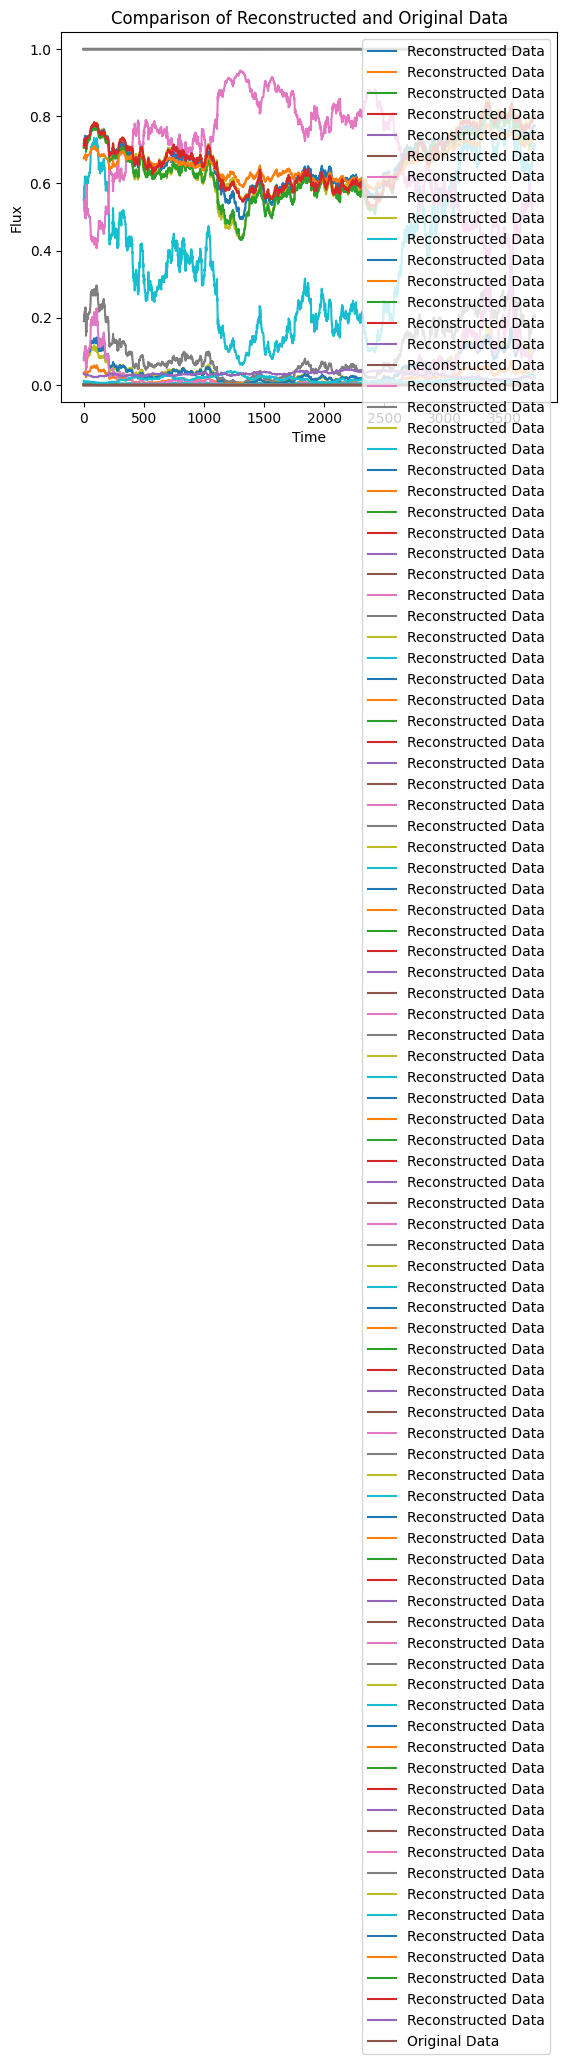

In [59]:
# Select a random sample from the data for comparison
sample_index = np.random.randint(low=0, high=original_data.shape[1])

# Plot the reconstructed data
time_steps = np.arange(original_data.shape[0])  # Generate time steps from 0 to the number of time steps in the data
plt.plot(time_steps, reconstructed_data[:, sample_index], label='Reconstructed Data')

# Plot the original data
plt.plot(time_steps, original_data[:, sample_index, 0], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Reconstructed and Original Data')
plt.legend()
plt.show()


In [85]:
original_data
print(original_data.shape)
print(original_data[0,13,0:10])
print(original_data[1,13,0:10])
print(original_data[2,13,0:10])
print(original_data[0:10,13,0])

(3754, 15, 95)
[0.         0.         0.99904139 0.99904139 0.         0.
 0.97761663 0.         0.         8.39      ]
[0.         0.         1.00448527 1.00448527 0.         0.
 0.98015803 0.         0.         8.39      ]
[0.         0.         1.00448527 1.00448527 0.         0.
 0.98015803 0.         0.         8.39      ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


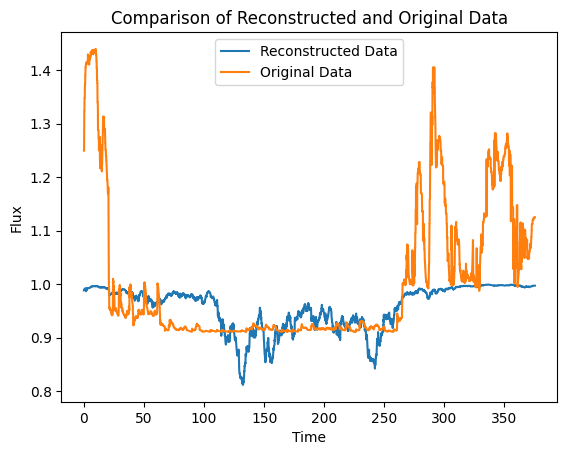

12
[1.24930249 1.24930249 1.2995076  ... 1.1245821  1.1251515  1.1251515 ]


In [88]:
# Select a random sample from the data for comparison
sample_index = np.random.randint(low=0, high=original_data.shape[1])

# Select the specific flux dimension to plot
flux_index = 44 # Change this value to select a different flux dimension

# Plot the reconstructed data
time_steps = np.arange(original_data.shape[0])/10  # Generate time steps from 0 to the number of time steps in the data
plt.plot(time_steps, reconstructed_data[:, sample_index, flux_index], label='Reconstructed Data')

# Plot the original data
plt.plot(time_steps, original_data[:, sample_index, flux_index], label='Original Data')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Reconstructed and Original Data')
plt.legend()
plt.show()

print(sample_index)
print(original_data[:, sample_index, flux_index])
